In [1]:
import pandas as pd
import cbsodata
import matplotlib.pyplot as plt
import numpy as np
import functools as ft
from datetime import datetime

todayDate = datetime.today().strftime('%Y_%m_%d')
pd.set_option('display.max_columns', 40)

plt.rcParams["figure.figsize"] = (18, 4)

###################################
# https://cbsodata.readthedocs.io/en/latest/readme_link.html

# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.cpb.nl/sites/default/files/publicaties/download/cpb-technical-background-document-bvar-models-used-cpb.pdf
###################################

In [2]:
#### WHERE TO SAVE DATA'
output = "../output_mo_qt/"
figures = "../figures/"	

macro_data_cbs, you lose 1995 because of seasonal adjustment


C:\Users\jpark\AppData\Local\Temp\ipykernel_41864\3689301611.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data.index = pd.date_range(start = start_date,  periods = data.shape[0], freq = "Q").to_period('Q')
C:\Users\jpark\AppData\Local\Temp\ipykernel_41864\3689301611.py:55: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  all_data.index = pd.date_range(start=start_date,  periods = all_data.shape[0], freq="Q").to_period('Q')


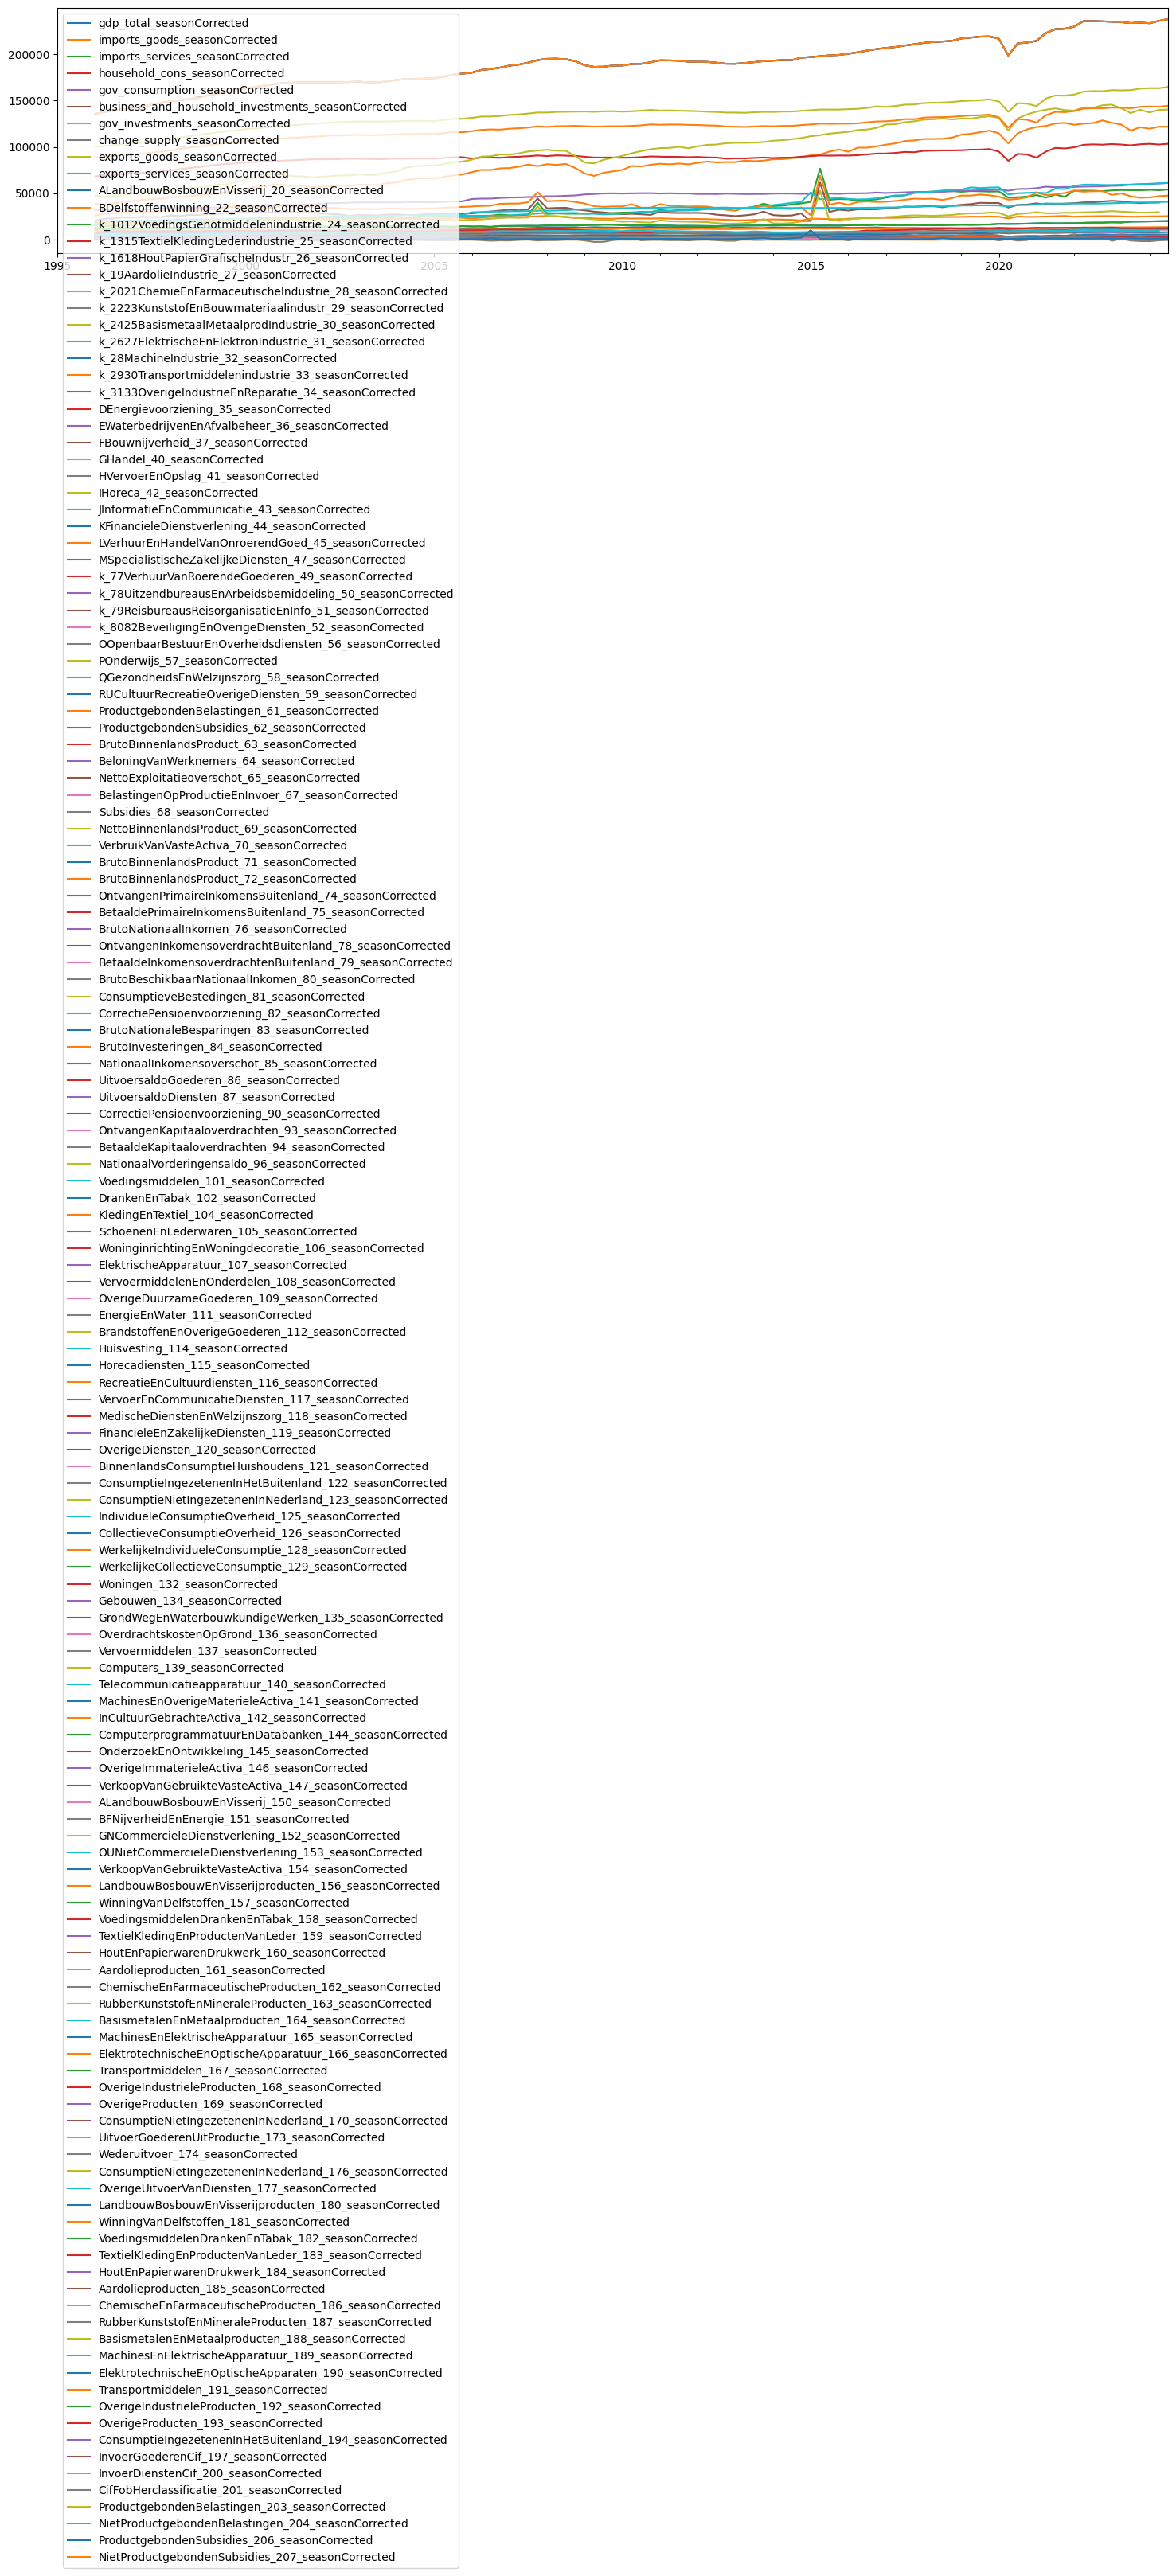

In [3]:
#### GDP
# https://opendata.cbs.nl/statline#/CBS/nl/dataset/84105NED/table?ts=1706684088769
# https://opendata.cbs.nl/statline#/CBS/nl/dataset/84087NED/table?ts=1696490590802

def macro_data_cbs(identifier, verbose = False):
    print("macro_data_cbs, you lose 1995 because of seasonal adjustment")
    start_date = '01/01/1995'

    if verbose:
        info = cbsodata.get_info(identifier)
        print(info)
        tables = pd.DataFrame(cbsodata.get_table_list())

    # get data
    data = pd.DataFrame(cbsodata.get_data(identifier))

    if verbose:
        data.to_csv(output + "ramdata.csv")
        print(data)
        print(data.Perioden)

    data = data[data["SoortGegevens"] == 'Prijsniveau 2021, seizoengecorrigeerd']
    data = data[data['Perioden'].str.contains('kwartaal')]
    data.index = pd.date_range(start = start_date,  periods = data.shape[0], freq = "Q").to_period('Q')

    
    all_data = data
    # remove ID column
    all_data.drop(columns = ['ID','SoortGegevens','Perioden'], inplace = True)
    # remove Totaal columns
    all_data = all_data.loc[:, ~all_data.columns.str.contains('Totaal')]
    # remove Saldo columns
    all_data = all_data.loc[:, ~all_data.columns.str.contains('Saldo')]
    # remove CifFobCorrectie columns
    all_data = all_data.loc[:, ~all_data.columns.str.contains('CifFobCorrectie')]

    all_data.rename(columns = { 'BrutoBinnenlandsProduct_2': 'gdp_total', 
                                'Goederen_4': 'imports_goods',
                                'Diensten_5': 'imports_services',
                                'Huishoudens_9': 'household_cons',
                                'Overheid_10': 'gov_consumption',
                                'Totaal_11': 'total_investments',
                                'BedrijvenEnHuishoudens_12': 'business_and_household_investments',
                                'Overheid_13': 'gov_investments',
                                'VeranderingInVoorraden_14': 'change_supply',
                                'Goederen_16': 'exports_goods',
                                'Diensten_17': 'exports_services'}, inplace = True)
    
    all_data.columns = [col + "_seasonCorrected" for col in all_data.columns]


    ######################
    # Set data index
    ######################
    all_data.index = pd.date_range(start=start_date,  periods = all_data.shape[0], freq="Q").to_period('Q')
    # this adds one day, so that we can go to the first of a month
    all_data.index = pd.PeriodIndex(all_data.index, freq='Q').to_timestamp() #+ datetime.timedelta(days=1) #pd.offsets.QuarterEnd()

    return all_data

############################
# 85879NED  #Newest data,   https://opendata.cbs.nl/#/CBS/nl/dataset/85879NED/table
# 84105NED  #Classic table, https://opendata.cbs.nl/Statline/#/CBS/nl/dataset/84105NED/table?ts=1723637202741
############################
# You may need to change the above permenantly, base year changed from 2015 to 2021 (in function above)

NLD_basic_macro_data = macro_data_cbs(identifier = '85879NED', verbose = False)
NLD_basic_macro_data.to_csv(output + "cbs_basic_macro_qt.csv")

NLD_basic_macro_data.plot()
plt.title('')
plt.savefig(figures + "NLD_basic_macro_data.png")




price_cbs


C:\Users\jpark\AppData\Local\Temp\ipykernel_41864\2725894899.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.index = pd.date_range(start='01/01/1996', periods = data.shape[0], freq="M").to_period('M')


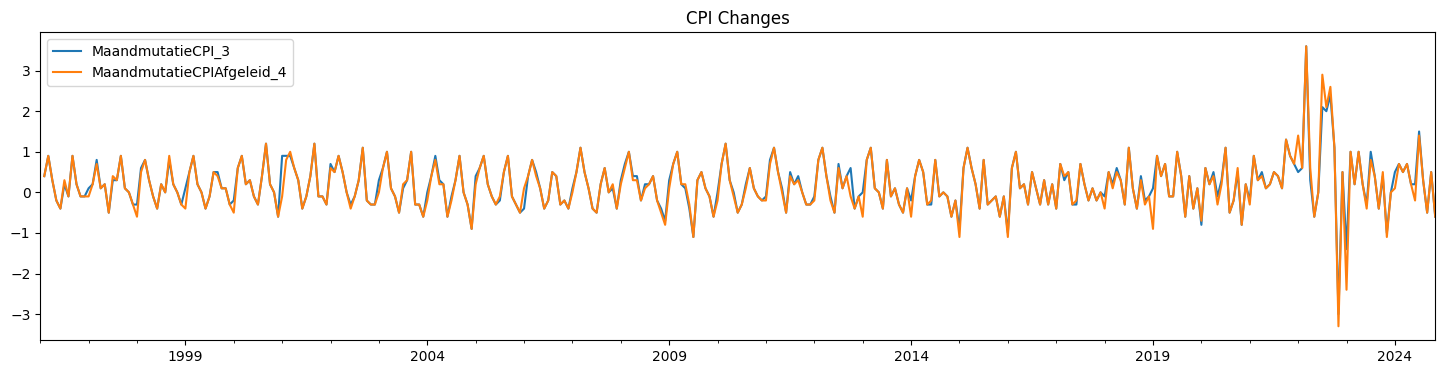

In [4]:

def price_cbs(identifier = '83131NED', verbose = False):
    print("price_cbs")
 
    data = pd.DataFrame(cbsodata.get_data(identifier))

    data = data[data['Bestedingscategorieen'] == '000000 Alle bestedingen']
    data = data[(data['Perioden'].str.len()) > 4]

    if verbose:
        print(data)
        print(data.Perioden)
    ######################
    # Set data index
    ######################
    data.index = pd.date_range(start='01/01/1996', periods = data.shape[0], freq="M").to_period('M')
    cpi1 = data[['CPI_1', 'CPIAfgeleid_2', 'MaandmutatieCPI_3', 'MaandmutatieCPIAfgeleid_4']]

    # this adds one day, so end jan becomes first feb
    cpi1.index = pd.PeriodIndex(cpi1.index, freq='M').to_timestamp() #+ datetime.timedelta(days=1) #pd.offsets.MonthEnd()

    return cpi1

cpi_mo = price_cbs(verbose = False)
cpi_mo.to_csv(output + "cbs_cpi_mo.csv")
cpi_mo[['MaandmutatieCPI_3', 'MaandmutatieCPIAfgeleid_4']].plot()
plt.title('CPI Changes')
plt.savefig(figures + "cbs_cpi_mo.png")


wage_cbs


C:\Users\jpark\AppData\Local\Temp\ipykernel_41864\3147732074.py:17: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data.index = pd.date_range(start=start_date, periods = data.shape[0], freq="Q").to_period('Q')
c:\Users\jpark\vscode\NowCast_Data_v2\.venv\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


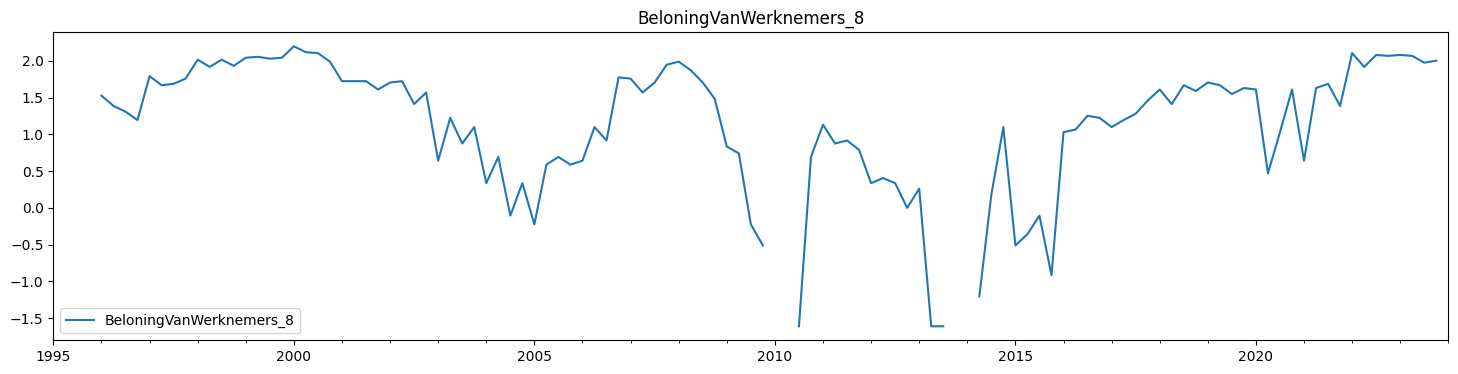

In [5]:

def wage_cbs(identifier = '84163NED', verbose = False):
    print("wage_cbs")
    start_date = '01/01/1995'

    data = pd.DataFrame(cbsodata.get_data(identifier))

    if verbose:
        print(data)
        print(data.Perioden)

    data = data[data['BedrijfstakkenBranchesSBI2008'] == 'A-U Alle economische activiteiten']
    data = data[(data['Perioden'].str.len()) > 4]

    ######################
    # Set data index
    ######################
    data.index = pd.date_range(start=start_date, periods = data.shape[0], freq="Q").to_period('Q')

    # this adds one day, so end jan becomes first feb
    data.index = pd.PeriodIndex(data.index,freq='Q').to_timestamp()  # + datetime.timedelta(days=1) #pd.offsets.QuarterEnd()

    data = data[['BeloningSeizoengecorrigeerd_2', 'Loonkosten_7', 'BeloningVanWerknemers_8']]

    return data

wages_qt = wage_cbs(verbose = False)
wages_qt.to_csv(output + "cbs_wages_qt.csv")

np.log(wages_qt[['BeloningVanWerknemers_8']]).plot()
plt.title('BeloningVanWerknemers_8')
plt.savefig(figures + "cbs_wages_qt.png")

cbs_consumer_conf


C:\Users\jpark\AppData\Local\Temp\ipykernel_41864\1347641559.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.index = pd.date_range(start='04/01/1986', periods = data.shape[0], freq="M").to_period('M')


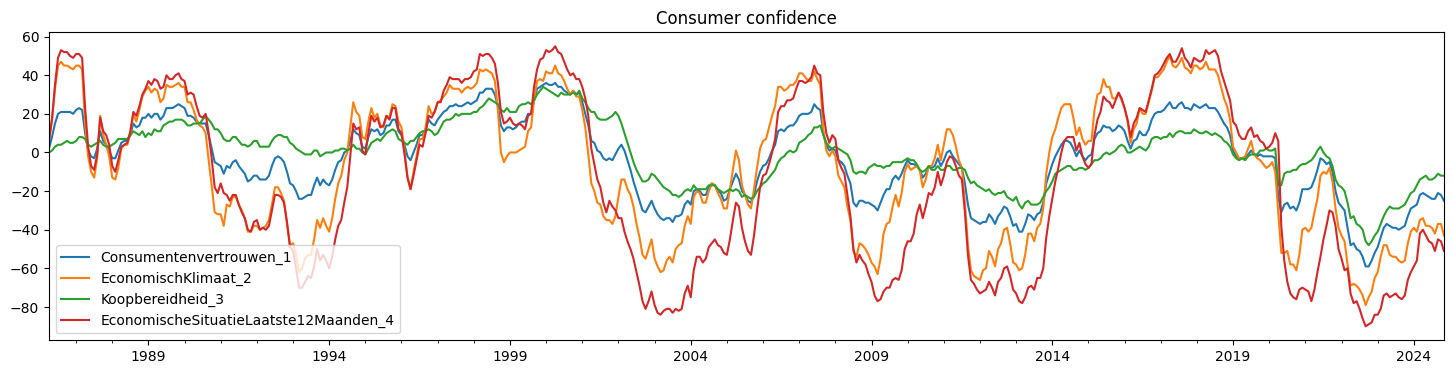

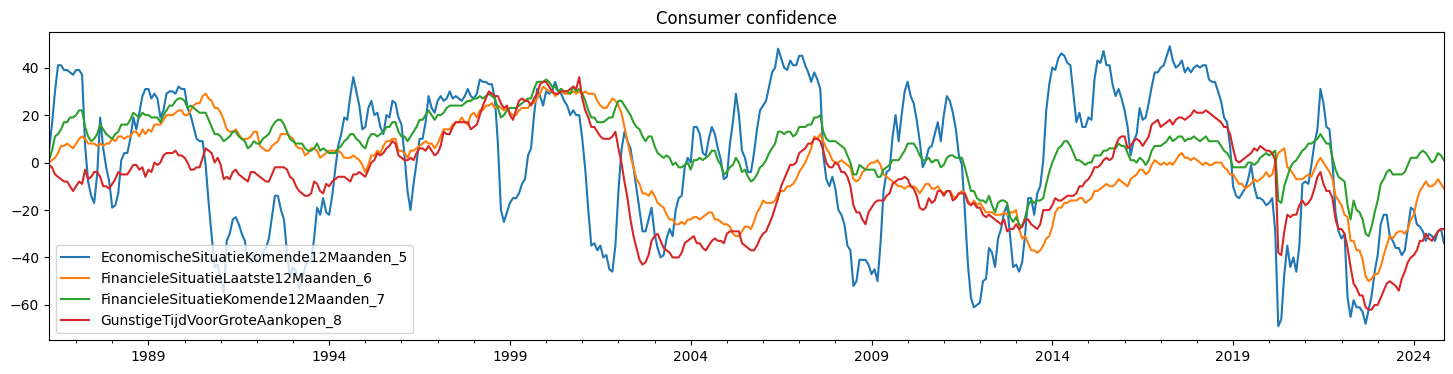

In [6]:

def consumer_confidence_cbs(identifier = '83693NED', verbose = False):
    print("cbs_consumer_conf")
    

    data = pd.DataFrame(cbsodata.get_data(identifier))

    if verbose:
        print(data)
        data.to_csv("consumer_vertrouw.csv")

    data = data[(data['Perioden'].str.len()) > 4]
    data = data[['Consumentenvertrouwen_1', 'EconomischKlimaat_2', 'Koopbereidheid_3', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8']]

    ######################
    # Set data index
    ######################
    data.index = pd.date_range(start='04/01/1986', periods = data.shape[0], freq="M").to_period('M')

    # this adds one day, so end jan becomes first feb
    data.index = pd.PeriodIndex(data.index, freq='M').to_timestamp()  # + datetime.timedelta(days=1) #pd.offsets.MonthEnd()

    return data

consumer_confd_mo = consumer_confidence_cbs(verbose = False)
consumer_confd_mo.to_csv(output +"cbs_consumer_confd_mo.csv")

consumer_confd_mo[['Consumentenvertrouwen_1', 'EconomischKlimaat_2', 'Koopbereidheid_3', 'EconomischeSituatieLaatste12Maanden_4']].plot()
plt.title('Consumer confidence')
plt.savefig(figures + "consumer_confd_1_mo.png")

consumer_confd_mo[['EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8']].plot()
plt.title('Consumer confidence')
plt.savefig(figures + "consumer_confd_2_mo.png")

bankrupt_cbs


C:\Users\jpark\AppData\Local\Temp\ipykernel_41864\80082453.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.index = pd.date_range(start='01/01/1981', periods=data.shape[0], freq="M").to_period('M')


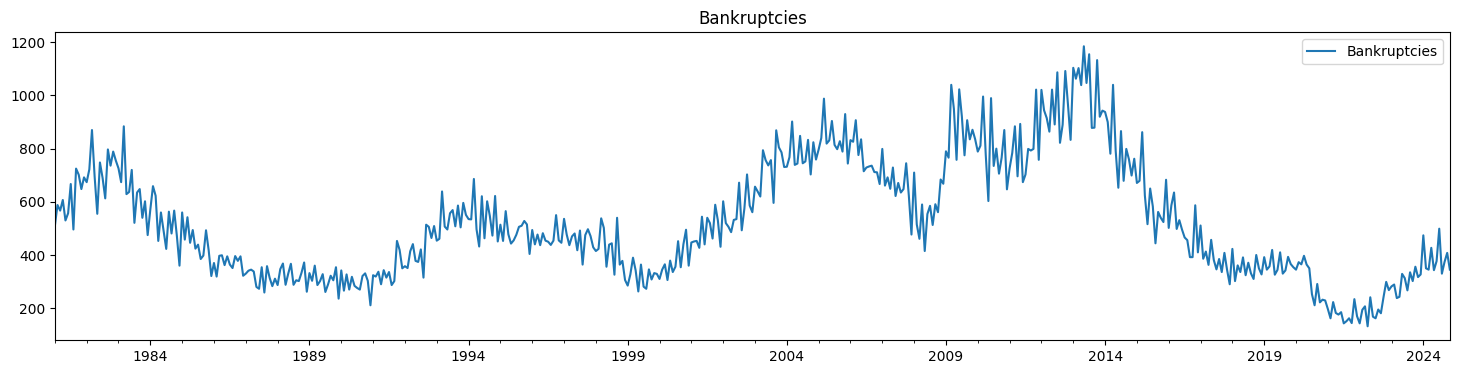

In [7]:

def bankrupt_cbs(identifier = '82242NED', verbose = False):
    print("bankrupt_cbs")
    

    data = pd.DataFrame(cbsodata.get_data(identifier))

    if verbose:
        print(data)

    # remove jaardata
    data = data[(data['Perioden'].str.len()) > 4]
    # remove kwarteldata
    filter = data['Perioden'].str.contains('kwartaal')
    data = data[~filter]

    data = data[data['TypeGefailleerde'] == 'Totaal rechtsvormen Nederland/buitenland']
    data.drop(columns=['ID'], inplace=True)

    data = data[['UitgesprokenFaillissementen_1']]
    data.columns = ['Bankruptcies']

    ######################
    # Set data index
    ######################
    data.index = pd.date_range(start='01/01/1981', periods=data.shape[0], freq="M").to_period('M')

    # this adds one day, so end jan becomes first feb
    data.index = pd.PeriodIndex(data.index, freq='M').to_timestamp()  # + datetime.timedelta(days=1) #pd.offsets.MonthEnd()

    return data

bankrupt_mo = bankrupt_cbs(verbose = False)
bankrupt_mo.to_csv(output + "cbs_bankrupt_mo.csv")

bankrupt_mo.plot()
plt.title('Bankruptcies')
plt.savefig(figures + "Bankruptcies.png")


producer_confidence


C:\Users\jpark\AppData\Local\Temp\ipykernel_41864\1370566400.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.index = pd.date_range(start='01/01/1985', periods=data.shape[0], freq="M").to_period('M')


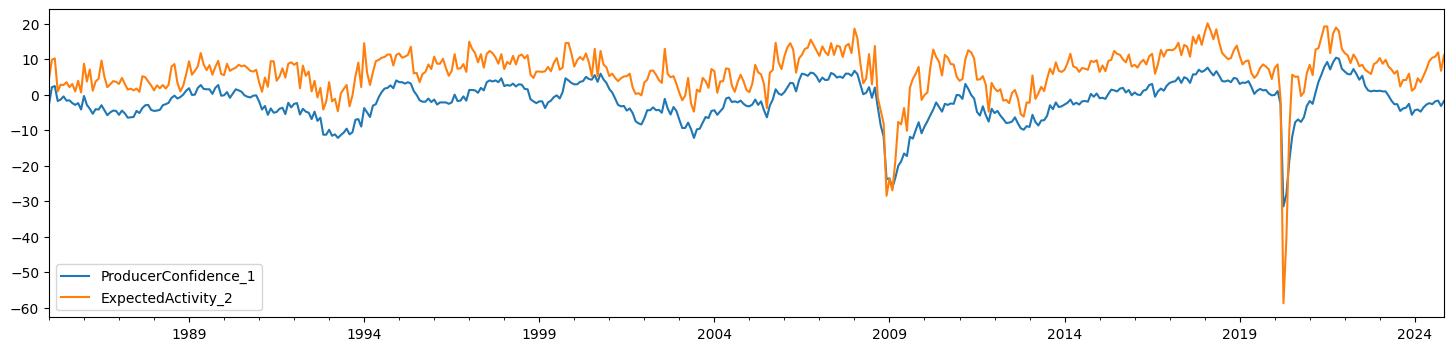

In [8]:

def producer_confidence( identifier = '81234eng', verbose = False):
    print("producer_confidence")
   
    data = pd.DataFrame(cbsodata.get_data(identifier))

    if verbose:
        print(data)

    data = data[data['SectorBranchesSIC2008'] =='C Manufacturing']
    data = data[data['Margins'] == 'Value']
    data = data[['Periods', 'ProducerConfidence_1', 'ExpectedActivity_2']]

    ######################
    # Set data index
    ######################
    data.index = pd.date_range(start='01/01/1985', periods=data.shape[0], freq="M").to_period('M')

    # this adds one day, so end jan becomes first feb
    data.index = pd.PeriodIndex(data.index, freq='M').to_timestamp()  # + datetime.timedelta(days=1) #pd.offsets.MonthEnd()
    data.drop(columns = ['Periods'], inplace = True)

    return data

producer_confd_mo = producer_confidence(verbose = False)
producer_confd_mo.to_csv(output + "cbs_producer_confd_mo.csv")

producer_confd_mo.plot()

plt.savefig(figures + "producer_confd_mo.png")

business utilization


C:\Users\jpark\AppData\Local\Temp\ipykernel_41864\2096965980.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_final.index = pd.date_range(start='01/01/2012', periods=df_final.shape[0], freq="M").to_period('M')


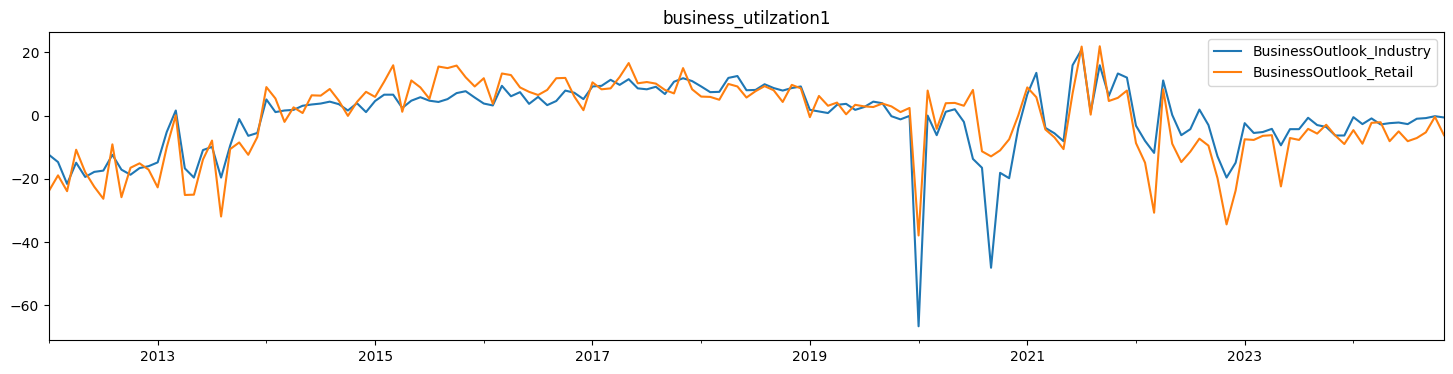

In [9]:
def business_utilzation( identifier = '85612ENG', verbose = False):
    print("business utilization")

    data = pd.DataFrame(cbsodata.get_data(identifier))

    if verbose:
        print(data)

    sectors = ['C Industry, H-S services and 45+47', '47 Retail trade (not in motor vehicles)']

    sectors1 = []
    for i in sectors:
        data1 = data[data['SectorBranchesSBI2008'] == i]
        data1 = data1[data1['Margins'] == 'Value']
        data1 = data1[['Periods', 'SectorBranchesSBI2008', 'BusinessSituationNextThreeMonths_3']]
        data1.set_index('Periods', inplace=True)
        sectors1.append(data1)

    df_final = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'),
                         sectors1)

    ######################
    # Set data index
    ######################
    df_final.index = pd.date_range(start='01/01/2012', periods=df_final.shape[0], freq="M").to_period('M')

    # this adds one day, so end jan becomes first feb
    df_final.index = pd.PeriodIndex(df_final.index,
                                    freq='M').to_timestamp()  # + datetime.timedelta(days=1) #pd.offsets.QuarterEnd()

    df_final = df_final[['BusinessSituationNextThreeMonths_3_x', 'BusinessSituationNextThreeMonths_3_y']]
    df_final.columns = ['BusinessOutlook_Industry', 'BusinessOutlook_Retail']


    return df_final

business_utilzation1 = business_utilzation(verbose = False)
business_utilzation1.to_csv(output + "cbs_business_utilzation_mo.csv")
business_utilzation1.plot()

plt.title('business_utilzation1')
plt.savefig(figures + "business_utilzation1_mo.png")
plt.show()